# **Trabajo Practico N°1** Organizacion de Datos 75.06 2do cuatrimestre
## Integrantes: Sofía Javes, Gastón Frenkel, Tomás Emanuel, Valentina Adelsflügel, Víctor Zacarías



El objetivo principal del trabajo será aplicar técnicas de análisis exploratorio, preprocesamiento
de datos, agrupamiento, clasificación y regresión sobre el set de datos provisto por la empresa Properati correspondiente a
anuncios de propiedades en venta de la República Argentina publicados durante el año 2021.

# Análisis Exploratorio

### Descripción y clasificación de las variables
Para clasificar cada variable se utilizan los siguientes tipos:
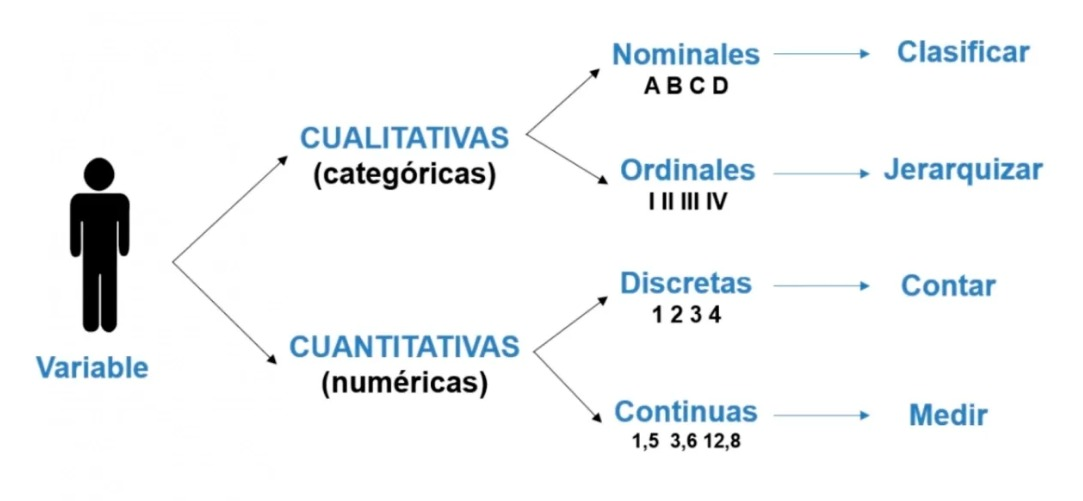
- id: Identificador del aviso. No es único: si el aviso es actualizado por la inmobiliaria (nueva versión del aviso) se crea un nuevo registro con la misma id pero distintas fechas: de alta y de baja. **(Cualitativa nominal)**
- start_date: Fecha de alta del aviso. **(Cualitativa ordinal)**
- end_date: Fecha de baja del aviso. **(Cualitativa ordinal)**
- created_on: Fecha de alta de la primera versión del aviso. **(Cualitativa ordinal)**
- place: Campos referidos a la ubicación de la propiedad o del desarrollo.**(Cualitativa nominal)**
- lat: Latitud. **(Cuantitativa continua)**
- lon: Longitud. **(Cuantitativa continua)**
- l1: Nivel administrativo 1: país. **(Cualitativa nominal)**
- l2: Nivel administrativo 2: usualmente provincia. **(Cualitiva nominal)**
- l3: Nivel administrativo 3: usualmente ciudad. **(Cualitativa nominal)**
- l4: Nivel administrativo 4: usualmente barrio. **(Cualitativa nominal)**
- property: Campos relativos a la propiedad (vacío si el aviso es de un desarrollo/proyecto). **(Cualitativa nominal)**
- operation: Tipo de operación (Venta, Alquiler). **(Cualitativa nominal)**
- type: Tipo de propiedad (Casa, Departamento, PH....). **(Cualitativa nominal)**
- rooms: Cantidad de ambientes (útil en Argentina). **(Cualitativa ordinal)**
- bedrooms: Cantidad de dormitorios (útil en el resto de los países). **(Cualitativa ordinal)**
- surface_total: Superficie total en m². **(Cuantitativa continua)**
- surface_covered: Superficie cubierta en m². **(Cuantitativa continua)**
- price: Precio publicado en el anuncio. **(Cuantitativa continua)**
- currency: Moneda del precio publicado. **(Cualitativa nominal)**
- title: Título del anuncio. **(Cualitativa nominal)**

Importación de bibliotecas a utilizar.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
#from geopy.geocoders import Nominatim 

Se carga el dataset en un dataframe de Pandas y se realiza una copia para no trabajar sobre el original.

In [2]:
ds_properaty_original = pd.read_csv('properati_argentina_2021.csv')    

In [3]:
ds_properati = ds_properaty_original.copy()    
ds_properati.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


Procedemos a cambiar los nombres de las columnas *place_l2*, *place_l3* y *place_l4* de modo que sean más descriptivas.

In [4]:
ds_properati.rename(columns = {'place_l2':'provincia', 'place_l3':'ciudad', 'place_l4':'barrio'}, inplace = True)
ds_properati.head(4)

,id,start_date,end_date,created_on,latitud,longitud,provincia,ciudad,barrio,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro


Se realiza un análisis introductorio incluyendo el tamaño del dataset y los tipos de dato de cada columna.


In [6]:
ds_properati.shape

(460154, 20)

In [7]:
ds_properati.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
provincia                    object
ciudad                       object
barrio                       object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

Seleccionamos los datos que se van a utilizar:
únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados
en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD). Por lo tanto, analizamos qué datos tenemos en cada una de esas variables.

In [8]:
ds_properati.operation.unique().tolist()

['Venta', 'Alquiler', 'Alquiler temporal']

Vemos que las operaciones no son sólo Venta, por lo que eliminamos las filas que contengan Alquiler y Alquiler temporal ya que no nos interesan en este trabajo. (Mantenemos los NaNs porque serás tratados mas adelante)

In [9]:
ds_properati = ds_properati.drop(ds_properati.index[(ds_properati["operation"] != "Venta") & (ds_properati["property_currency"] != "NaN")])

Como se puede apreciar, ahora solo quedan entradas de propiedades en venta

In [10]:
ds_properati.operation.unique().tolist()

['Venta']

Ahora las filas que contengan datos diferentes a Casa, PH o Departamento.

In [11]:
ds_properati = ds_properati.drop(ds_properati.index[~ds_properati.property_type.isin(["Casa","Departamento","PH", "NaN"])])

Y por ultimo, eliminamos las filas que contengan un Tipo de cambio diferente a USD

In [12]:
ds_properati = ds_properati.drop(ds_properati.index[(ds_properati["property_currency"] != "USD") & (ds_properati["property_currency"] != "NaN")])

Por ultimo, eliminamos las filas de las propiedades que no sean de Capital Federal.

In [13]:
ds_properati = ds_properati.drop(ds_properati.index[ds_properati["provincia"] != "Capital Federal"])

Podemos ver que todas las columnas elegidas quedan con los valores deseados.

In [14]:
display(ds_properati.operation.unique().tolist())
display(ds_properati.property_type.unique().tolist())
display(ds_properati.property_currency.unique().tolist())
display(ds_properati.provincia.unique().tolist())


['Venta']

['Casa', 'Departamento', 'PH']

['USD']

['Capital Federal']

In [50]:
ds_properati.shape

(94249, 15)

Vemos que redujimos el tamaño del DataSet ampliamente.

# Variables Cuantitativas
Estas pueden ser:
- Cuantitativas discretas: Estas variables toman valores numéricos siendo que entre dos valores consecutivos de las mismas no existen valores intermedios. Pueden tomar un conjunto a lo sumo numerable de valores, vinculándose generalmente al proceso de contar. 
- Cuantitativas continuas: Estas variables también toman valores numéricos, pero entre dos valores de la variable existen infinitos valores intermedios, asociándose generalmente al proceso de medir. 

En el caso de nuestro data set las variables cuantitativas, como ya se indicó mas arriba, son:
latitud, longitud, property_surface_total, property_surface_covered, price. Para trabajar sólo sobre estas se crea un nuevo data frame y se calculan medidas de resumen: media, mediana, q1, q3, moda.

In [15]:
df_cuantitativas = ds_properati[["latitud", "longitud", "property_surface_total", "property_surface_covered", "property_price"]]
dic_cuanti = []
for i in df_cuantitativas.columns:
  dic_cuanti.append({'variable': i, 'media': df_cuantitativas[i].mean(), 
                                    'moda': df_cuantitativas[i].mode().to_list(),
                                    'mediana': df_cuantitativas[i].median(),
                                    'rango': df_cuantitativas[i].max() - df_cuantitativas[i].min(),
                                    'primer cuartil': df_cuantitativas[i].quantile(0.25),
                                    'tercer cuartil': df_cuantitativas[i].quantile(0.75)})

pd.DataFrame(dic_cuanti)

,variable,media,moda,mediana,rango,primer cuartil,tercer cuartil
0,latitud,-34.591481,[-34.5412501],-34.59579,2.956880e+01,-34.615975,-34.577413
1,longitud,-58.449795,[-58.4729664],-58.43900,1.733786e+01,-58.466522,-58.408862
2,property_surface_total,109.092970,[50.0],65.00000,1.369900e+05,45.000000,105.000000
3,property_surface_covered,87.931932,[40.0],58.00000,2.169990e+05,40.000000,88.000000
4,property_price,226238.207185,[110000.0],143900.00000,2.139500e+07,95000.000000,237000.000000


A continuación se muestran gráficos de las distribuciones de estas variables cuantitativas. Los resultados observados pueden estar afectados por los valores faltantes que más adelante se tratarán.

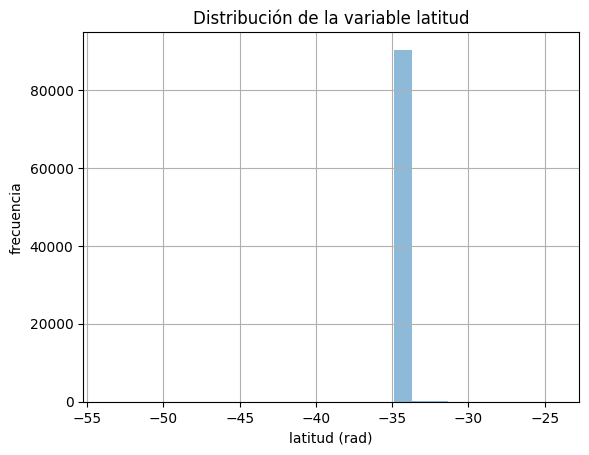

In [16]:
plt.title('Distribución de la variable latitud')
plt.hist(ds_properati['latitud'], bins = 25 , alpha = 0.5) 
plt.xlabel("latitud (grados)") 
plt.ylabel("frecuencia")
plt.grid(True)
plt.show()

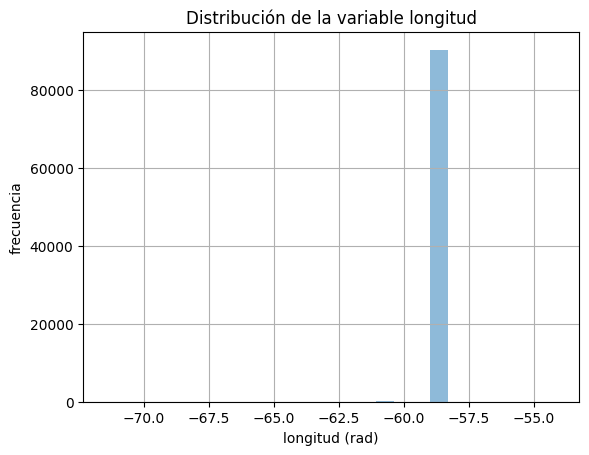

In [17]:
plt.title('Distribución de la variable longitud')
plt.hist(ds_properati['longitud'], bins = 25 , alpha = 0.5) 
plt.xlabel("longitud (grados)") 
plt.ylabel("frecuencia")
plt.grid(True)
plt.show()

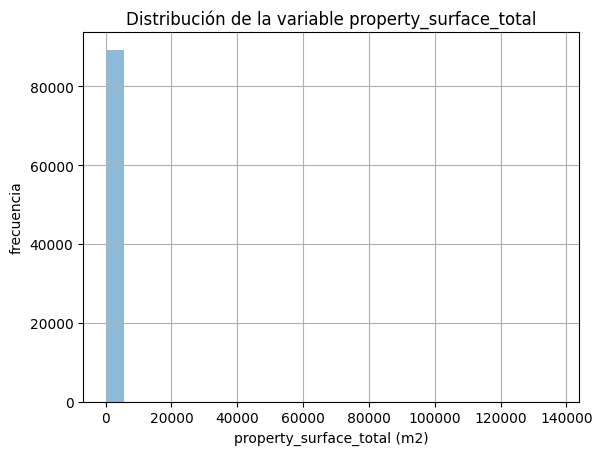

In [18]:
plt.title('Distribución de la variable property_surface_total')
plt.hist(ds_properati['property_surface_total'], bins = 25 , alpha = 0.5) 
plt.xlabel("property_surface_total (m2)")
plt.ylabel("frecuencia")
plt.grid(True)
plt.show()

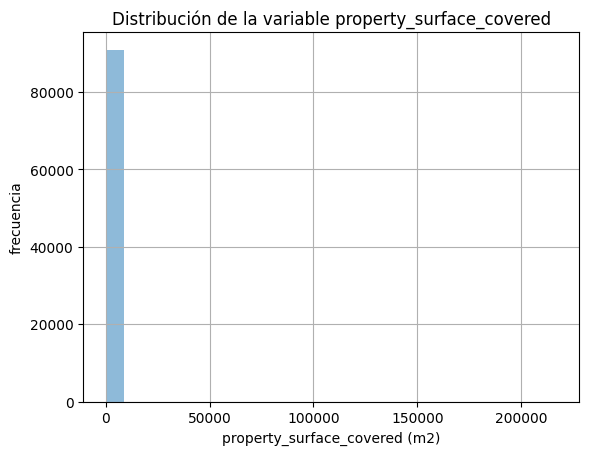

In [19]:
plt.title('Distribución de la variable property_surface_covered')
plt.hist(ds_properati['property_surface_covered'], bins = 25 , alpha = 0.5) 
plt.xlabel("property_surface_covered (m2)") 
plt.ylabel("frecuencia")
plt.grid(True)
plt.show()

Hasta acá notamos una distribución uniforme de estas variables.

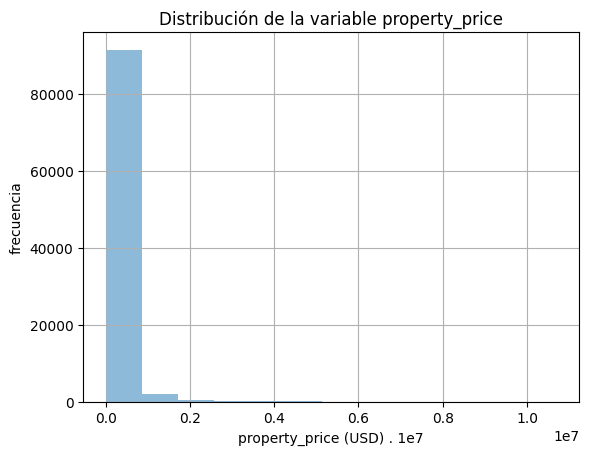

In [20]:
plt.title('Distribución de la variable property_price')
plt.hist(ds_properati['property_price'], bins = 25 , alpha = 0.5) 


scale_factor = 0.5
xmin, xmax = plt.xlim()
plt.xlim(xmin * scale_factor, xmax * scale_factor)


plt.xlabel("property_price (USD) . 1e7") 
plt.ylabel("frecuencia")
plt.grid(True)
plt.show()


# Variables Cualitativas
Estas pueden ser: 

- Nominales: Se diferencian de las Ordinales ya que no necesariamente llevan un orden. Dentro de esta clasificacion podrian llegar a ser de texto o numericas:
    - Texto: Estas podrian ser, por ejemplo el color de ojos de una persona, o algo no necesariamente ordenable.
    - Numericas: Pueden ser por ejemplo ids, o numeros de telefono.
- Ordinales: Una variable cualitativa ordinal podria ser aquella que tenga una escala establecida, con valores ordenados. 
    - Texto: Esta puede ser por ejemplo las medallas de un torneo (Oro,plata,bronce), que mantienen un orden siendo la mejor Oro y la pero la de Bronce.
    - Numericas

En el principio del tp ya definimos todos las variables cualitativas que encontramos.
Ahora mostramos los valores posibles de cada variable cualitativa, exeptuando las que tienen solamente un valor.


In [21]:
df_cual_nominal = ds_properati[["property_type","ciudad","property_rooms","property_title"]]
dic_cual_nominal = []
for cual in df_cual_nominal.columns:
  dic_cual_nominal.append({"variable": cual, "tipos" : ds_properati[cual].unique().tolist()})
pd.DataFrame(dic_cual_nominal)


,variable,tipos
0,property_type,"[Casa, Departamento, PH]"
1,ciudad,"[nan, Boca, Once, Boedo, Flores, Nuñez, Retiro..."
2,property_rooms,"[4.0, 3.0, 2.0, 10.0, 5.0, 1.0, nan, 6.0, 7.0,..."
3,property_title,"[VENTA CASA LLAVE EN MANO - COSTA ESMERALDA , ..."


Calculamos la frecuencia de cada categoria segun los valores tomados.

Para cada categoria tenemos:

In [22]:
ds_agrupado_PT = ds_properati["property_type"].value_counts()
ds_agrupado_PL_3 = ds_properati["ciudad"].value_counts()
ds_agrupado_PR = ds_properati["property_rooms"].value_counts()
ds_agrupado_CO = ds_properati["created_on"].value_counts() 


Con sus respectivas tablas con la frecuencia:

In [23]:
display(ds_agrupado_PT)

Departamento    80829
PH               9266
Casa             4154
Name: property_type, dtype: int64

Para property Rooms (ambientes)

In [24]:
display(ds_agrupado_PR)

3.0     26714
2.0     26496
4.0     16405
1.0     15084
5.0      5171
6.0      1854
7.0       741
8.0       359
9.0       151
10.0      107
11.0       33
12.0       30
14.0       17
15.0       12
13.0        6
16.0        4
17.0        4
18.0        3
20.0        3
30.0        2
36.0        2
19.0        2
35.0        1
32.0        1
24.0        1
40.0        1
28.0        1
Name: property_rooms, dtype: int64

Para ciudad:

In [25]:
display(ds_agrupado_PL_3)

Palermo                 14308
Belgrano                 8898
Caballito                7168
Recoleta                 6282
Villa Urquiza            4673
Almagro                  4081
Nuñez                    3546
Villa Crespo             3189
Flores                   3110
Barrio Norte             2975
Balvanera                2553
Colegiales               1951
Villa Devoto             1921
Villa del Parque         1829
Saavedra                 1829
Puerto Madero            1493
San Telmo                1380
San Cristobal            1300
San Nicolás              1295
Retiro                   1250
Barracas                 1246
Boedo                    1237
Floresta                 1195
Monserrat                1115
Parque Chacabuco         1073
Villa Pueyrredón         1011
Coghlan                   984
Villa Luro                727
Mataderos                 719
Chacarita                 697
Liniers                   668
Villa Ortuzar             662
Parque Patricios          639
Villa Luga

Y por ultimo para las property bedrooms:

In [26]:
display(ds_agrupado_CO)

2021-12-16    4674
2021-02-13    2121
2021-11-03    1016
2021-08-03     836
2021-04-10     819
              ... 
2021-11-21      18
2021-12-19      13
2021-01-02      12
2021-10-24      10
2021-11-27       1
Name: created_on, Length: 365, dtype: int64

Se puede observar que para la categoria de ciudad la zona mas frecuente de venta de propiedades es en Palermo, ademas de esto se puede ver que el tipo de propiedad mas frecuente en venta es el de Departamento. Para el caso de las ambientes, se puede ver que el mas frecuente son 3 y para las habitaciones es 1. No le vemos mucho sentido mostrar todos los tipos de "property title" ya que no hay valores frecuentes. Por ultimo, se puede ver que se crearon publicaciones todos los dias del año siendo el mas frecuente el 16 de Diciembre con 17417 publicaciones
 Se podria hacer un grafico con los resultados mas frecuentes (para mejor visualizacion). Si hay muchos tipos lo truncamos en los 10 valores mas frecuentes para poder ver mejor.


<AxesSubplot: title={'center': 'Frecuencia de valores de la variable ciudad'}, xlabel='frecuencia', ylabel='zona'>

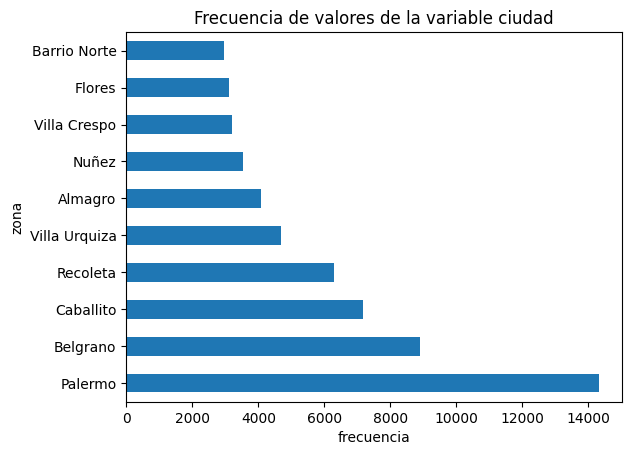

In [27]:
ds_agrupado_PL_3[:10].plot(kind = "barh", title="Frecuencia de valores de la variable ciudad", xlabel="frecuencia",ylabel="zona")

<AxesSubplot: title={'center': 'Frecuencia de valores de la variable Property Title'}, xlabel='frecuencia', ylabel='Tipo de Venta'>

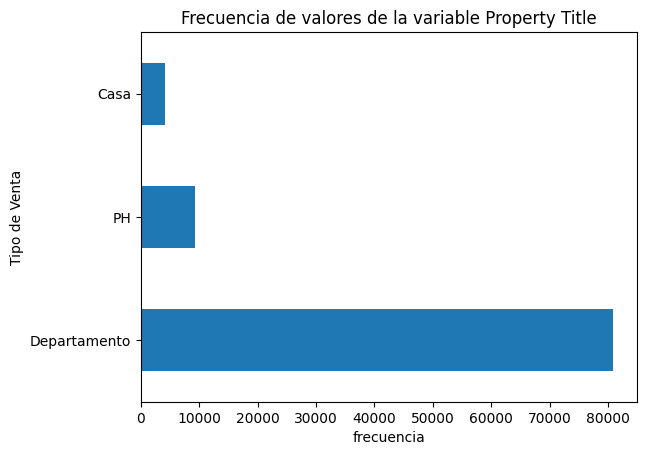

In [28]:
ds_agrupado_PT.plot(kind = "barh", title="Frecuencia de valores de la variable Property Title", xlabel="frecuencia",ylabel="Tipo de Venta")

<AxesSubplot: title={'center': 'Frecuencia de valores de la variable Property Rooms'}, xlabel='frecuencia', ylabel='Cantidad de ambientes'>

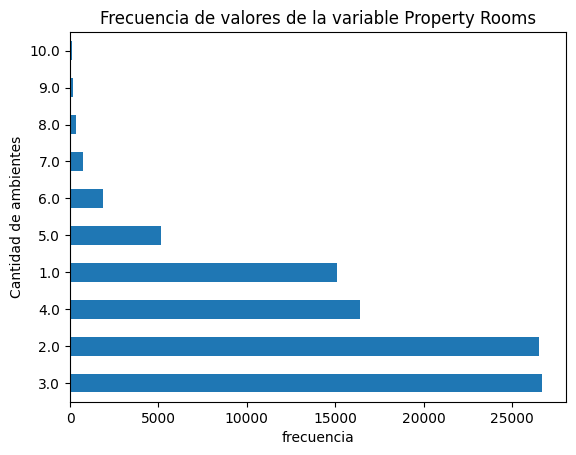

In [29]:
ds_agrupado_PR[:10].plot(kind = "barh", title="Frecuencia de valores de la variable Property Rooms", xlabel="frecuencia",ylabel="Cantidad de ambientes")

<AxesSubplot: title={'center': 'Frecuencia de valores de la variable created_on'}, xlabel='frecuencia', ylabel='Fecha de Publicacion'>

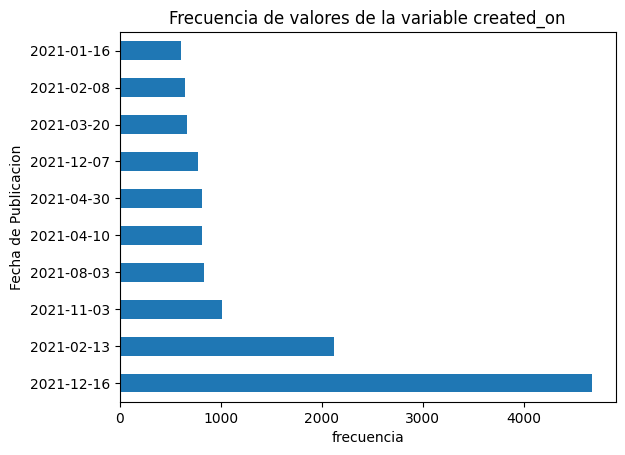

In [30]:
ds_agrupado_CO[:10].plot(kind = "barh", title="Frecuencia de valores de la variable created_on", xlabel="frecuencia",ylabel="Fecha de Publicacion")

**Variables irrelevantes en el analisis**

Se descartan las columnas de **id** (que no son de utilidad para el análisis ya que no aportan información alguna sobre las propiedades), **property_bedrooms** (ya que tal como decía la descripción, sólo es de utilidad en otros países y no en Argentina) y por último **property_title** (porque solamente es una forma que tiene el vendedor de identificar su anuncio, que suele contener la información que ya figura en las otras variables).

In [31]:
ds_properati.drop(["id", "property_bedrooms", "property_title"], axis=1, inplace=True) ##ver si sacar o no property bedrooms
ds_properati.reset_index(drop=True,inplace=True)
ds_properati.head()

,start_date,end_date,created_on,latitud,longitud,provincia,ciudad,barrio,place_l5,place_l6,operation,property_type,property_rooms,property_surface_total,property_surface_covered,property_price,property_currency
0,2021-09-09,2021-09-26,2021-09-09,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Casa,4.0,171.0,133.0,210000.0,USD
1,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,3.0,58.0,55.0,82900.0,USD
2,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,4.0,70.0,70.0,99000.0,USD
3,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,NaN,NaN,NaN,Venta,Departamento,4.0,NaN,104.0,146000.0,USD
4,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,NaN,NaN,NaN,Venta,PH,4.0,NaN,73.0,250000.0,USD


## Covarianza y Correlación

Tanto la covarianza como la correlación son medidas de asociación lineal entre dos variables.
La Covarianza indica la dirección/sentido de esa asociación lineal y la Correlación mide tanto la fuerza como el sentido de dicha asociación lineal.

El valor (magnitud) de la covarianza depende las unidades en que se miden las variables.
Si las escalas de medida de las variables fueran muy diferentes, la variabilidad estaría dominada por las variables con mayores magnitudes.

La Correlación se define como la covarianza de los datos estandarizados, por lo que evita el problema de las diferencias en las escalas de medición. Se obtiene dividiendo la covarianza de dos variables por el producto de sus desvíos estándar.

Los valores del coeficiente de correlación van de -1 a 1. Cuanto más cerca esté de 1 (lineal perfecta positiva) o -1 (lineal perfecta negativa), más estrechamente relacionadas estarán las dos variables. El signo positivo significa la dirección de la correlación, es decir, si una de las variables aumenta, se supone que la otra también aumentará. Al contar con una muestra poblacional se calcula la correlación mediante un estimador muestral que es el de Pearson.



In [32]:
matriz_cov = ds_properati.cov(numeric_only=True)
matriz_cov

,latitud,longitud,place_l6,property_rooms,property_surface_total,property_surface_covered,property_price
latitud,0.033022,-0.012722,NaN,0.001329,4.511110e+00,4.395853e-01,9.460629e+02
longitud,-0.012722,0.085632,NaN,-0.003288,-4.357227e+00,-3.476163e-01,2.135205e+03
place_l6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
property_rooms,0.001329,-0.003288,NaN,2.033897,9.189482e+01,7.385269e+01,2.139160e+05
property_surface_total,4.511110,-4.357227,NaN,91.894819,9.611880e+05,4.225679e+05,2.668280e+07
property_surface_covered,0.439585,-0.347616,NaN,73.852695,4.225679e+05,9.819366e+05,1.777143e+07
property_price,946.062929,2135.204988,NaN,213915.986352,2.668280e+07,1.777143e+07,1.015082e+11


In [33]:
matriz_corr=ds_properati.corr(numeric_only=True)
matriz_corr

,latitud,longitud,place_l6,property_rooms,property_surface_total,property_surface_covered,property_price
latitud,1.000000,-0.239235,NaN,0.005521,0.025348,0.002352,0.016635
longitud,-0.239235,1.000000,NaN,-0.008324,-0.015056,-0.001155,0.023314
place_l6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
property_rooms,0.005521,-0.008324,NaN,1.000000,0.067211,0.076097,0.488934
property_surface_total,0.025348,-0.015056,NaN,0.067211,1.000000,0.604311,0.085235
property_surface_covered,0.002352,-0.001155,NaN,0.076097,0.604311,1.000000,0.056238
property_price,0.016635,0.023314,NaN,0.488934,0.085235,0.056238,1.000000


A continuación se muestra la matriz de correlación en un Heatmap:

<AxesSubplot: >

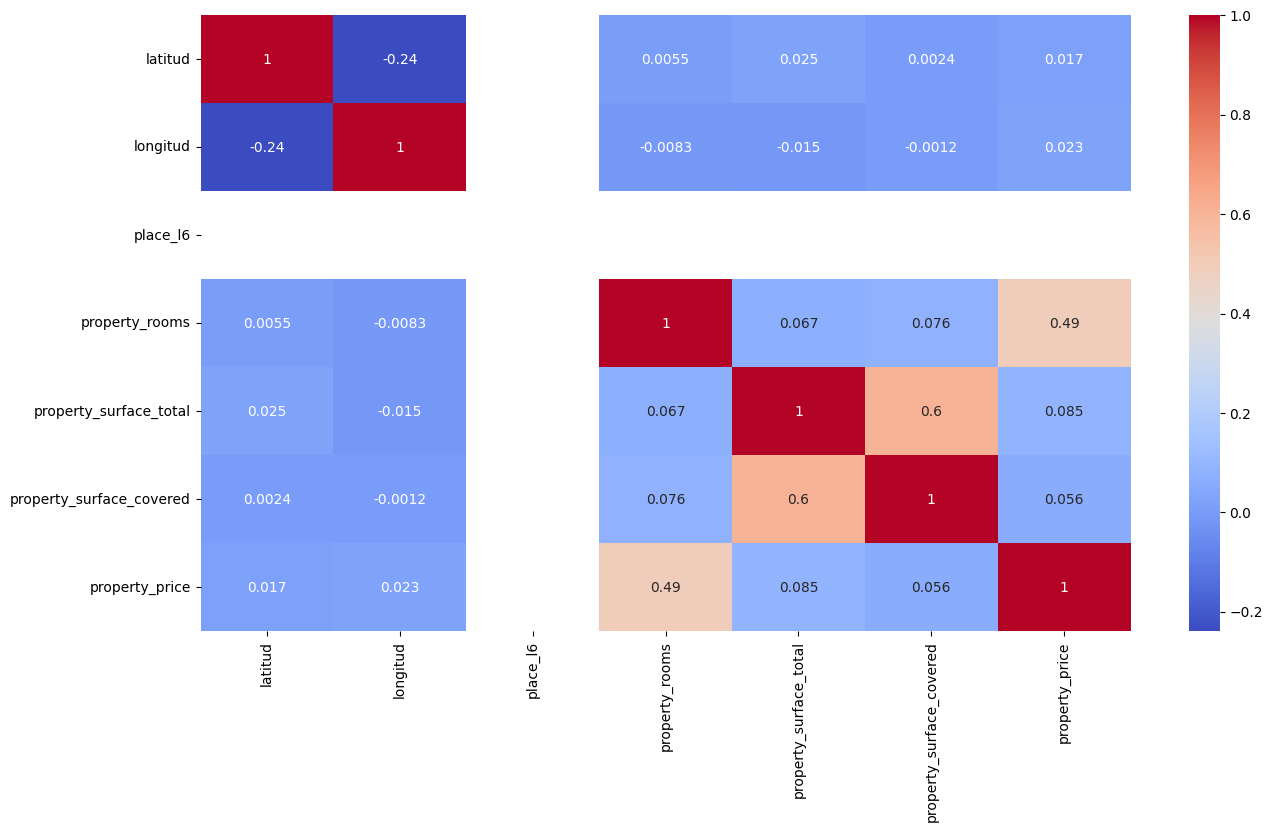

In [34]:
plt.figure(figsize = (15,8))
display(sns.heatmap(matriz_corr, annot = True, cmap='coolwarm'))


Se orbserva una la "cruz" blanca correspondiente a los valores NaN (100%) de la columna *place_l6*.
Por otro lado, siguiendo la escala de colores aquellas celdas más cercanas al rojo presentan una buena correlación lineal positiva (lineal creciente). En este caso no se observan correlaciones cercanas a -1, que también implicarían relación linealidad pero decreciente.

Teniendo esto en cuenta, vemos que las variables que mejor se relacionan linealmente son: (Ignoramos la diagonal, dado que es la correlación de la variable consigo misma que siempre es perfecta)
- *property_surface_total* con *property_surface_covered*  ($\rho$ = 0.60)
- *property_rooms* con *property_price* ($\rho$ = 0.49)




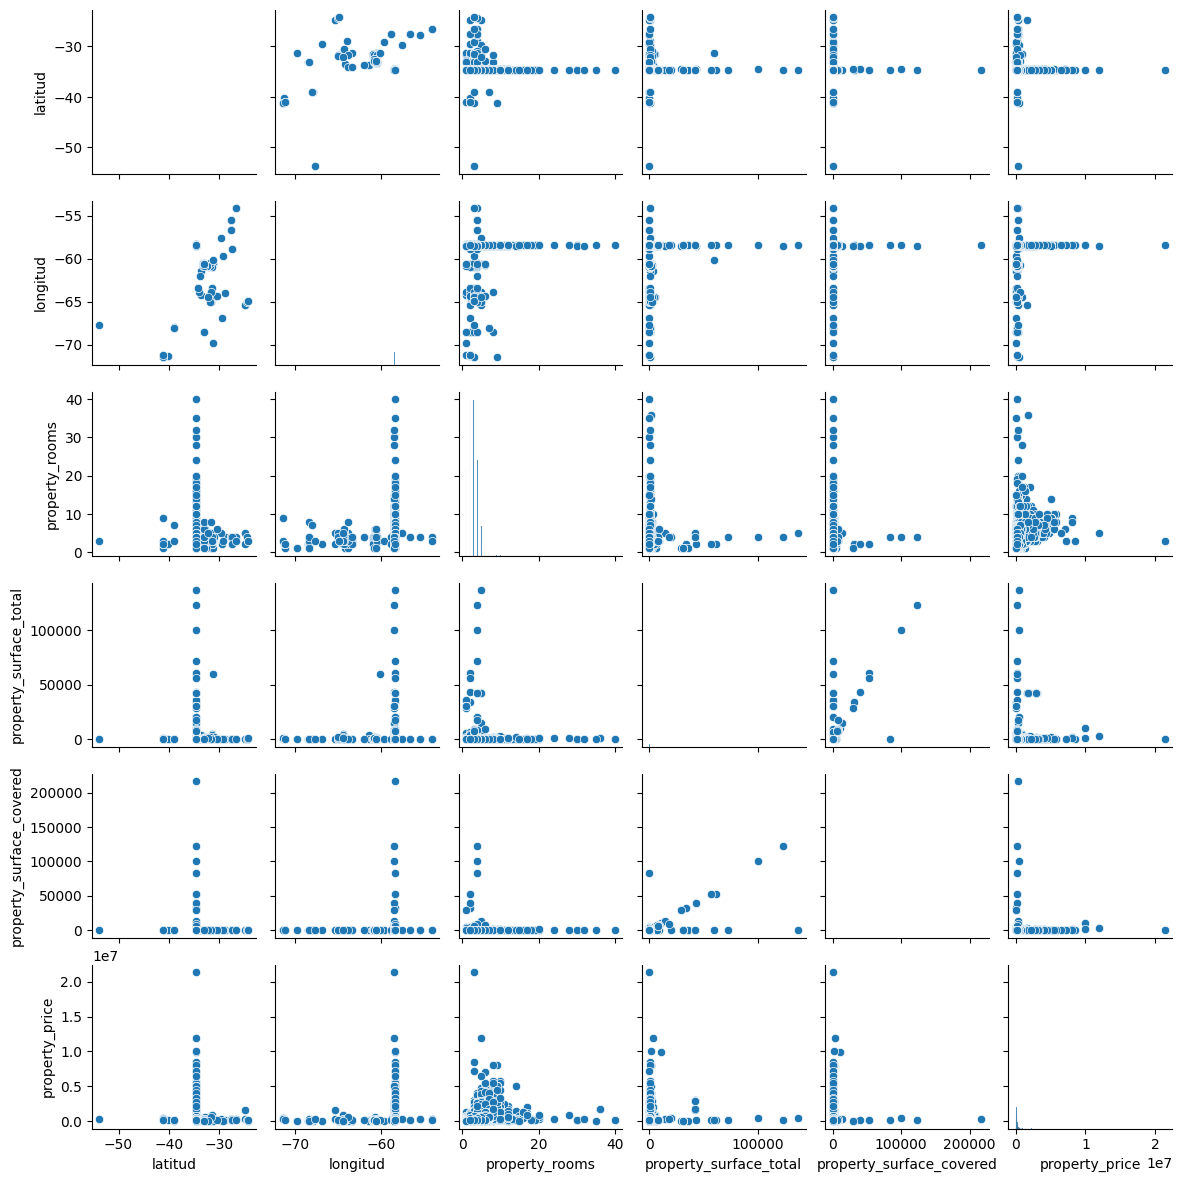

In [52]:
sns.pairplot(ds_properati, height=2)

En este pairplot podemos ver las distribuciones bivariadas. En especial nos sirve para efectivamente ver que *property_surface_total* con *property_surface_covered*  tienen una bastante tendencia lineal tal como exponía su correlacion de pearson (0.6). Por otro lado, *property_rooms* con *property_price* no es tan apropiada para ajustar linealmente.

### Datos Faltantes

##### Columnas 

Para todas las columnas se realiza la cuenta del porcentaje de los datos faltantes

In [36]:
porcentajes = ds_properati.isna().sum() / len(ds_properati) * 100
porcentajes

start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.957602
longitud                      3.957602
provincia                     0.000000
ciudad                        0.442445
barrio                       96.134707
place_l5                    100.000000
place_l6                    100.000000
operation                     0.000000
property_type                 0.000000
property_rooms                1.107704
property_surface_total        5.139577
property_surface_covered      3.558658
property_price                0.000000
property_currency             0.000000
dtype: float64

In [37]:
ds_properati["barrio"].value_counts()

Palermo Hollywood    1576
Palermo Chico        1092
Palermo Soho          804
Palermo Viejo         171
Name: barrio, dtype: int64

Se puede notar que las columnas con mayor datos faltantes son las de place_l6, place_l5 y barrio, siendo los primeros 2 un 100% de datos faltantes y barrio teniendo un 95% de datos faltantes, siendo Palermo Hollywood el dato no nulo mas frecuente

Realizamos un grafico a partir de las variables con respecto al total del dataset

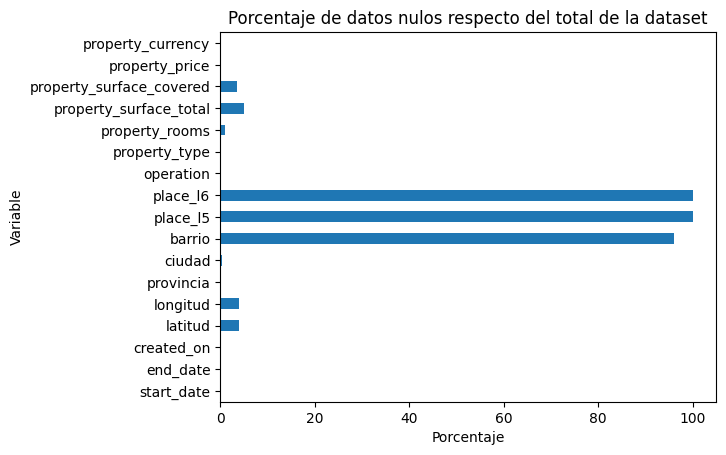

<Figure size 200x200 with 0 Axes>

In [38]:
porcentajes.plot(kind = "barh", title="Porcentaje de datos nulos respecto del total de la dataset", xlabel="Porcentaje",ylabel="Variable")
plt.figure(figsize=(2, 2))
plt.show()

##### Filas

Por otro lado, calculamos el porcentaje de datos faltantes por cada registro sobre el total de datos del registro.

In [39]:
porcentaje_Nan_fila = (ds_properati.isnull().sum(axis=1) / ds_properati.columns.size * 100).sort_values(ascending=False).value_counts()
porcentaje_Nan_fila

17.647059    79504
23.529412     8315
29.411765     3075
11.764706     2799
35.294118      423
41.176471      124
47.058824        9
dtype: int64

In [40]:
ds_properati[ds_properati.isnull().sum(axis=1) == 8]


,start_date,end_date,created_on,latitud,longitud,provincia,ciudad,barrio,place_l5,place_l6,operation,property_type,property_rooms,property_surface_total,property_surface_covered,property_price,property_currency
1300,2021-02-09,2021-06-05,2021-02-09,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,390.0,795000.0,USD
6470,2021-05-17,2021-06-05,2021-05-17,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Departamento,NaN,90.0,NaN,250000.0,USD
14917,2021-10-18,9999-12-31,2021-10-18,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Departamento,NaN,26.0,NaN,85000.0,USD
27253,2021-05-27,2021-06-05,2021-05-27,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,421.0,610000.0,USD
36572,2021-03-23,2021-06-05,2021-03-23,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,150.0,195000.0,USD
45435,2021-06-30,9999-12-31,2021-06-30,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,396.0,820000.0,USD
73689,2021-04-10,2021-04-14,2021-04-10,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,167.0,175000.0,USD
93890,2021-01-05,2021-03-01,2021-01-05,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,190.0,190000.0,USD
93891,2021-01-05,2021-03-01,2021-01-05,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,80.0,120000.0,USD


In [41]:
(ds_properati.isnull().sum(axis=1)).sort_values(ascending=False).value_counts()

3    79504
4     8315
5     3075
2     2799
6      423
7      124
8        9
dtype: int64

Se puede ver que hay 9 registros con 8 valores faltantes, siendo estos los registros con mas valores faltantes. Tambien se puede analizar que 79504 registros tienen 3 valores faltantes, por lo que se puede concluir que es mucho mas frecuente tener 3 registros faltantes. 

Se puede graficar estos porcentajes para obtener una mejor visualizacion de los datos

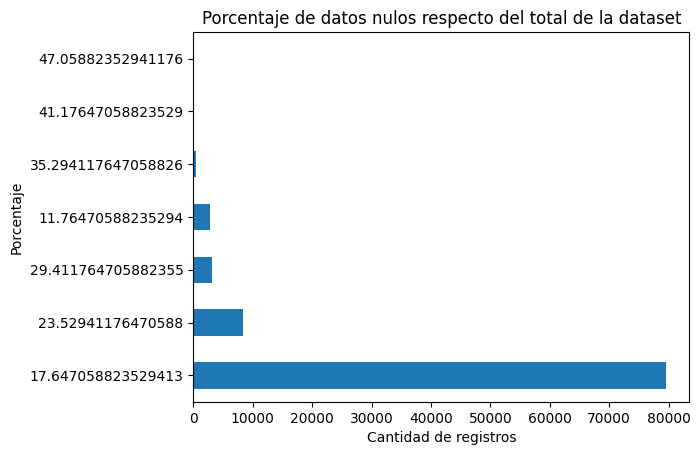

<Figure size 200x200 with 0 Axes>

In [42]:
porcentaje_Nan_fila.plot(kind = "barh", title="Porcentaje de datos nulos respecto del total de la dataset", xlabel="Cantidad de registros",ylabel="Porcentaje")
plt.figure(figsize=(2, 2))
plt.show()

A partir de este grafico se puede concluir que aproximadamente 79 mil registros tienen 16.6% de datos faltantes, siendo 16.6% el porcentaje mas frecuente de datos faltantes en un registro.

#### Estrategias Para datos faltantes

Opcion 1

Opcion 2

Opcion 3

Para las columnas de place_l5 y place_l6 decidimos usar la opcion 1 ya que la gran mayoria de valores son datos faltantes, por lo que no tendria sentido tomar una media de sus valores.


In [43]:
columnas_a_eliminar = ["place_l5","place_l6"]
ds_properati.drop(columnas_a_eliminar,axis='columns', inplace=True)

Analizamos qué hacer con *barrio*. En primer lugar listamos los valores de *ciudad* y *barrio* para ver qué representan.

In [72]:
ds_properati["ciudad"].unique()

array([nan, 'Boca', 'Once', 'Boedo', 'Flores', 'Nuñez', 'Retiro',
       'Almagro', 'Coghlan', 'Liniers', 'Palermo', 'Pompeya', 'Barracas',
       'Belgrano', 'Floresta', 'Recoleta', 'Saavedra', 'Balvanera',
       'Caballito', 'Chacarita', 'Mataderos', 'Monserrat', 'San Telmo',
       'Versalles', 'Agronomía', 'Colegiales', 'Tribunales', 'Villa Luro',
       'Parque Chas', 'Barrio Norte', 'Monte Castro', 'San Nicolás',
       'Villa Crespo', 'Villa Devoto', 'Villa Lugano', 'Constitución',
       'Puerto Madero', 'San Cristobal', 'Villa Ortuzar', 'Villa Urquiza',
       'Velez Sarsfield', 'Parque Chacabuco', 'Parque Patricios',
       'Villa Santa Rita', 'Villa del Parque', 'Parque Avellaneda',
       'Villa Pueyrredón', 'Villa General Mitre', 'Centro / Microcentro',
       'Villa Real', 'Congreso', 'Paternal', 'Abasto', 'Villa Riachuelo',
       'Parque Centenario', 'Villa Soldati', 'Las Cañitas', 'Catalinas'],
      dtype=object)

In [61]:
ds_properati["barrio"].unique()


array([nan, 'Palermo Chico', 'Palermo Soho', 'Palermo Viejo',
       'Palermo Hollywood'], dtype=object)

Aquí se puede observar que en el caso de Capital Federal *ciudad* hace referencia al barrio y que los valores de *barrio* no son relevantes frente a los otros. Por lo tanto, dada la alta cantidad de NaNs se procede a eliminar la columna.

In [65]:
ds_properati.drop("barrio", axis=1, inplace=True)
ds_properati

,start_date,end_date,created_on,latitud,longitud,provincia,ciudad,operation,property_type,property_rooms,property_surface_total,property_surface_covered,property_price,property_currency
0,2021-09-09,2021-09-26,2021-09-09,NaN,NaN,Capital Federal,NaN,Venta,Casa,4.0,171.0,133.0,210000.0,USD
1,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Venta,Departamento,3.0,58.0,55.0,82900.0,USD
2,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Venta,Departamento,4.0,70.0,70.0,99000.0,USD
3,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Venta,Departamento,4.0,NaN,104.0,146000.0,USD
4,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Venta,PH,4.0,NaN,73.0,250000.0,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94244,2021-01-05,2022-09-02,2021-01-05,-34.603245,-58.489810,Capital Federal,Villa del Parque,Venta,Departamento,4.0,130.0,100.0,220000.0,USD
94245,2021-01-05,2021-02-17,2021-01-05,-34.614063,-58.482814,Capital Federal,Villa del Parque,Venta,Departamento,3.0,68.0,60.0,161000.0,USD
94246,2021-01-05,2021-01-27,2021-01-05,-34.614175,-58.479062,Capital Federal,Villa del Parque,Venta,Departamento,1.0,51.0,30.0,75500.0,USD
94247,2021-01-05,2021-01-27,2021-01-05,-34.614175,-58.479062,Capital Federal,Villa del Parque,Venta,Departamento,1.0,37.0,31.0,74500.0,USD


Dado que contamos con las latitudes y longitudes de la ubicación de las observaciones, vamos a imputar los datos faltantes de *ciudad* usándolos si no son nulos.

In [96]:
from geopy.geocoders import Nominatim 

In [86]:
ds_properati["ciudad"].isnull().sum()

417

Tenemos 417 filas con *ciudad* NaN.

In [97]:
# ds_properati.reset_index(drop=True, inplace=True)
# ds_filas_con_ciudad_nan = ds_properati[ds_properati['ciudad'].isnull()]
# ds_filas_con_ciudad_nan.size

# geolocator = Nominatim(user_agent="tpDatos") 
# indice_ciudad_locator = 2
# # #para bajar la concurrencia
# # geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1/100)
# # ds_filas_con_ciudad_nan.apply(geocode)

# #obtengo una lista de filas del ds
# Row_list = []
# for i in range((ds_filas_con_ciudad_nan.shape[0])): 
#     Row_list.append(list(ds_filas_con_ciudad_nan.iloc[i, :])) 
    
# indice_longitud = ds_properati.columns.get_loc('longitud') 
# indice_latitud = ds_properati.columns.get_loc('latitud') 
# indice_ciudad = ds_properati.columns.get_loc('ciudad')


# #reemplazo los nans de ciudades usando sus coordenadas
# for fila in Row_list:
#     latitud = fila[indice_latitud]
#     longitud = fila[indice_longitud]

#     location = str(geolocator.geocode(str(latitud) + "," + str(longitud)))
#     fila[indice_ciudad] = location.split(",")[indice_ciudad_locator]
    
# Row_list

Siguiendo a esto, para las columnas de ciudad y property rooms tomamos la opcion 2 para tratar a sus datos faltantes como categorias extras, describiendolos como inexistentes.

In [ ]:
#ds_properati['ciudad'] = ds_properati['ciudad'].fillna("Ciudad no existe")
#ds_properati['property_rooms'] = ds_properati['property_rooms'].fillna("Ambientes inexistentes")

Para las columnas de latitud,longitud, property_surface_total y property_surface_covered adquirimos la estategia de la opcion 3 adoptando la media de sus valores totales no faltantes:

In [ ]:
ds_properati["latitud"] = ds_properati['latitud'].fillna(ds_properati['latitud'].mean())
ds_properati["longitud"] = ds_properati['longitud'].fillna(ds_properati['longitud'].mean())
ds_properati["property_surface_total"] = ds_properati['property_surface_total'].fillna(ds_properati['property_surface_total'].mean())
ds_properati["property_surface_covered"] = ds_properati['property_surface_covered'].fillna(ds_properati['property_surface_covered'].mean())
ds_properati

,start_date,end_date,created_on,latitud,longitud,provincia,ciudad,barrio,operation,property_type,property_rooms,property_surface_total,property_surface_covered,property_price,property_currency
0,2021-09-09,2021-09-26,2021-09-09,-34.591481,-58.449795,Capital Federal,NaN,NaN,Venta,Casa,4.0,171.00000,133.0,210000.0,USD
1,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,NaN,Venta,Departamento,3.0,58.00000,55.0,82900.0,USD
2,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,NaN,Venta,Departamento,4.0,70.00000,70.0,99000.0,USD
3,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,NaN,Venta,Departamento,4.0,109.09297,104.0,146000.0,USD
4,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,NaN,Venta,PH,4.0,109.09297,73.0,250000.0,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94244,2021-01-05,2022-09-02,2021-01-05,-34.603245,-58.489810,Capital Federal,Villa del Parque,NaN,Venta,Departamento,4.0,130.00000,100.0,220000.0,USD
94245,2021-01-05,2021-02-17,2021-01-05,-34.614063,-58.482814,Capital Federal,Villa del Parque,NaN,Venta,Departamento,3.0,68.00000,60.0,161000.0,USD
94246,2021-01-05,2021-01-27,2021-01-05,-34.614175,-58.479062,Capital Federal,Villa del Parque,NaN,Venta,Departamento,1.0,51.00000,30.0,75500.0,USD
94247,2021-01-05,2021-01-27,2021-01-05,-34.614175,-58.479062,Capital Federal,Villa del Parque,NaN,Venta,Departamento,1.0,37.00000,31.0,74500.0,USD


Podemos ver que ya no quedan valores faltantes en las columnas

In [ ]:
porcentajes = ds_properati.isna().sum() / len(ds_properati) * 100
porcentajes

start_date                   0.000000
end_date                     0.000000
created_on                   0.000000
latitud                      0.000000
longitud                     0.000000
provincia                    0.000000
ciudad                       0.442445
barrio                      96.134707
operation                    0.000000
property_type                0.000000
property_rooms               1.107704
property_surface_total       0.000000
property_surface_covered     0.000000
property_price               0.000000
property_currency            0.000000
dtype: float64

#### Busqueda Valores Atípicos - Univariado


A partir de un boxplot se hace el analisis de valores atipicos en forma univariada

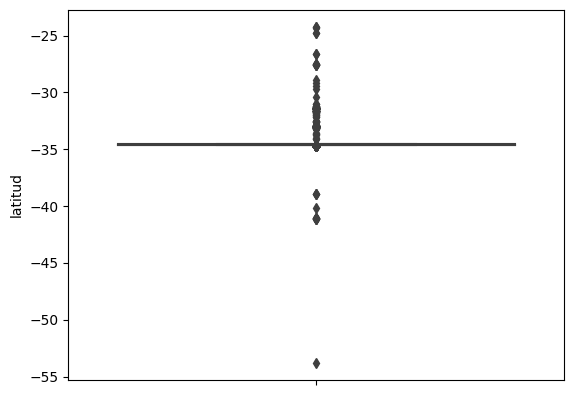

In [ ]:
#ds_properati['latitud'].plot.box(title="Boxplot variable latitud",xlabel="radianes",ylabel="latitud")  #medio feucho el gráfico q genera esto, no?
sns.boxplot(y=ds_properati.latitud)
plt.show()

Como se puede observar, la abrumadora mayoría de propiedades en venta se encuentran sobre una latitud sur de alrededor de 34º, lo cual coincide con la ubicación geográfica de la Ciudad Autónoma de Buenos Aires. Todo valor que se aleje, aunque sea en un par de grados, puede ser considerado un outlier ya que Capital Federal se encuentra a ≈34.6º latitud sur.

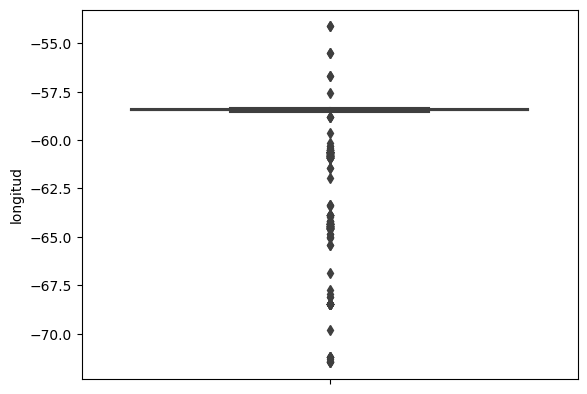

In [ ]:
#Boxplot de la variable longitud
sns.boxplot(y=ds_properati.longitud)
plt.show()

Lo mismo sucede con la longitud. La Ciudad Autónoma de Buenos Aires se encuentra a una longitud oeste de ≈58.43º, lo cual coincide con la gran mayoría de datos (comparando con el boxplot). Es por esto que cualquier entrada que se aleje de este valor puede ser considerado un outlier.

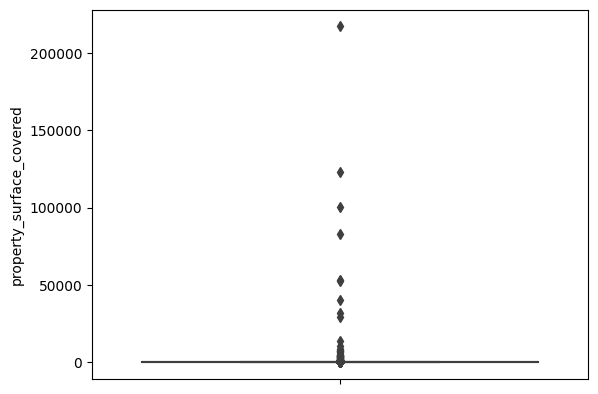

In [ ]:
#Boxplot de la variable property_surface_covered
sns.boxplot(y=ds_properati.property_surface_covered)
plt.show()

Como se puede observar, hay valores de superficie cubierta extremadamente grandes, que no solo no coinciden con la mayoría de entradas, sino que resultan inconcebibles para una propiedad en Capital Federal. Además, estos valores atípicos estiran el eje y del gráfico, resultando en que la mayoría de valores caigan cerca del 0. Una vez que estos valores atípicos sean corregidos, se volverá a graficar este box plot para ver la diferencia.

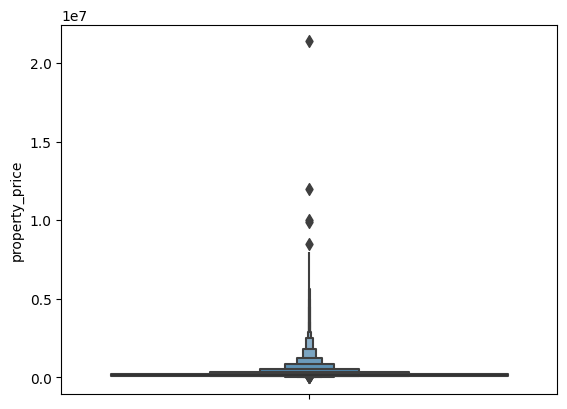

In [ ]:
#Boxlot de la variable property_price
sns.boxenplot(y=ds_properati.property_price)
plt.show()

Algo para decir al respecto?

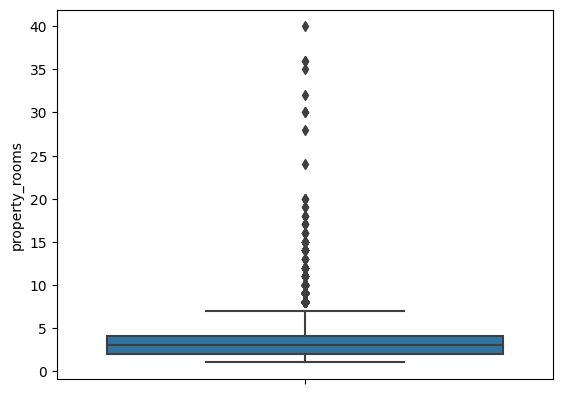

In [ ]:
#sns.boxenplot(y=ds_properati.property_rooms)
sns.boxplot(y=ds_properati.property_rooms)
plt.show()

Para la cantidad de ambientes, se puede observar que la mayoría de las entradas poseen una cantidad de entre 1 y 7, con la mayor concentración estando en ~3 o 4. Si bien hay entradas que llegan hasta los 10 ambientes, los cuales son poco comunes pero posibles (penthouses, mansiones, casas de varias plantas), sin lugar a duda se pueden observar valores que exceden lo esperable.

#### Busqueda Valores Atípicos - Multivariado

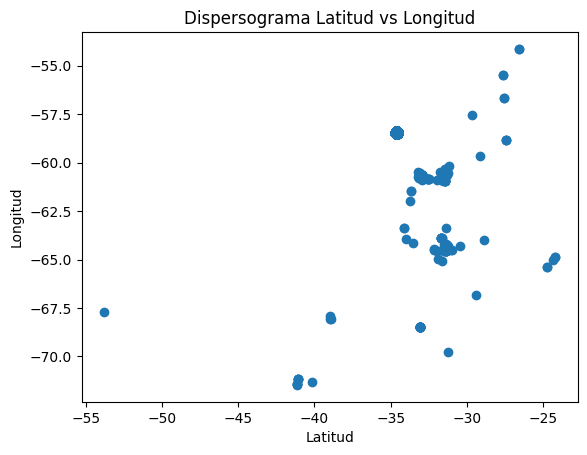

In [ ]:
plt.scatter(ds_properati.latitud, ds_properati.longitud)
plt.title('Dispersograma Latitud vs Longitud')
plt.xlabel('Latitud')
plt.ylabel('Longitud')
plt.show()

Como es de esperarse, hay una gran concentración de puntos en latitud sur ~35º y longitud oeste ~58º. Si bien hay otros clusters de puntos, como puede ser latitud sur ~32, longitud oeste ~61, es muy probable que estos correspondan a otras zonas de gran densidad poblacional, pero por fuera de la Capital Federal.

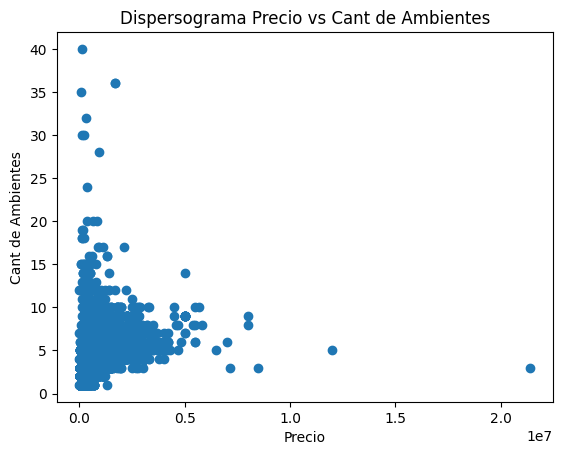

In [ ]:
plt.scatter(ds_properati.property_price, ds_properati.property_rooms)
plt.title('Dispersograma Precio vs Cant de Ambientes')
plt.xlabel('Precio')
plt.ylabel('Cant de Ambientes')
plt.show()

In [ ]:
vmedias = np.mean(ds_properati[['property_price', 'property_rooms']])
x_dif = ds_properati[['property_price','property_rooms']]-vmedias
cov=ds_properati[['property_price', 'property_rooms']].cov().values

inv_cov=np.linalg.inv(cov)
a=np.dot(x_dif, inv_cov)

mahal=np.dot(a,x_dif.T)
#ds_properati['mahal']=mahal.diagonal()

/home/gst-frenkel/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


MemoryError: Unable to allocate 66.2 GiB for an array with shape (94249, 94249) and data type float64

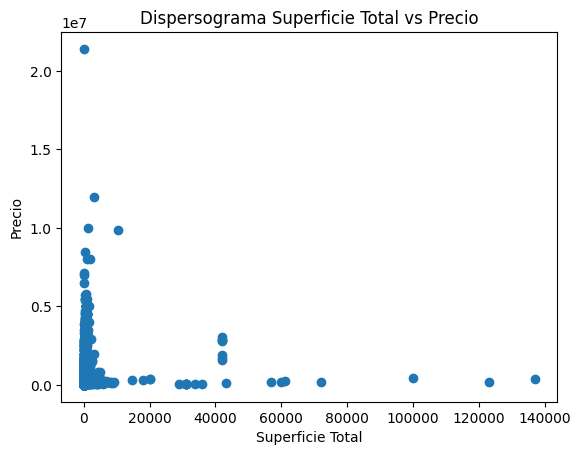

In [ ]:
plt.scatter(ds_properati.property_surface_total, ds_properati.property_price)
plt.title('Dispersograma Superficie Total vs Precio')
plt.xlabel('Superficie Total')
plt.ylabel('Precio')
plt.show()

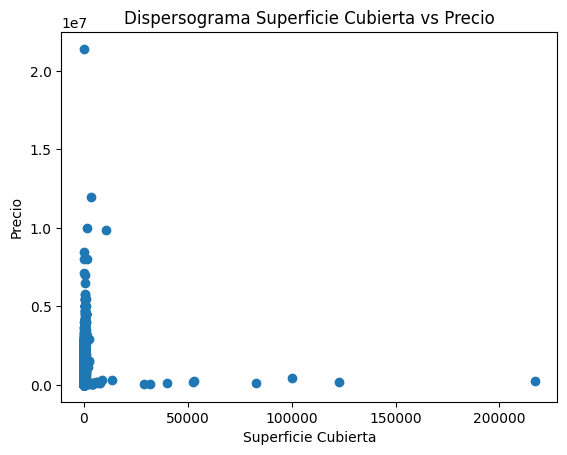

In [ ]:
#property_surface_covered-propery_price
plt.scatter(ds_properati.property_surface_covered, ds_properati.property_price)
plt.title('Dispersograma Superficie Cubierta vs Precio')
plt.xlabel('Superficie Cubierta')
plt.ylabel('Precio')
plt.show()

MOVER!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 




Como se desea predecir los precios en dólares de las propiedades en venta, se toma como target el campo property_price.

In [ ]:
modelo = ds_properati.columns.tolist()
modelo.remove("property_price")

ds_properati_x = ds_properati[modelo].copy()
ds_properati_y = ds_properati["property_price"].copy()

A fin de crear un modelo robusto, pero que tenga un buen número de casos para testear, se remueve el 20% del dataset para crear un set de evaluación, mientras que el restante 80% será utilizado para entrenar al modelo.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(ds_properati_x.values, ds_properati_y.values, test_size=0.2, random_state=6)

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 75399
# Datos Prueba: 18850


KeyError: 1